# Polydisperse Polymer Systems

This tutorial demonstrates creating realistic polydisperse polymer systems with different molecular weight distributions.

## Overview

Real polymers are **polydisperse** - chains of varying lengths. We'll:
1. Parse GBigSMILES with distribution specifications
2. Create distribution objects (Schulz-Zimm, Uniform, Poisson, Flory-Schulz)
3. Sample polymer chains
4. Analyze and visualize distributions

## Key Metrics

- **Mn**: Number-average molecular weight
- **Mw**: Weight-average molecular weight  
- **PDI**: Polydispersity Index = Mw/Mn (≥ 1)

PDI = 1.0 (monodisperse), 1.5-2.0 (controlled), >2.0 (broad)

## Step 1: Import Required Libraries

We'll need:
- **GBigSMILES parser**: To parse polymer notation with distribution specs
- **Distribution classes**: SchulzZimm, Uniform, Poisson, FlorySchulz
- **Chain generator**: To sample chains from distributions
- **Plotting tools**: To visualize and compare distributions

In [1]:
"""
Script version of `polymer-polydisperse-system.ipynb` using the current molpy API.

This focuses on:
- Parsing GBigSMILES with different polydisperse distributions
- Creating distribution objects via `create_polydisperse_from_ir`
- Sampling chains with `PolydisperseChainGenerator` + `SystemPlanner`
- Computing Mn/Mw/PDI and plotting sampled vs theoretical distributions
"""

'\nScript version of `polymer-polydisperse-system.ipynb` using the current molpy API.\n\nThis focuses on:\n- Parsing GBigSMILES with different polydisperse distributions\n- Creating distribution objects via `create_polydisperse_from_ir`\n- Sampling chains with `PolydisperseChainGenerator` + `SystemPlanner`\n- Computing Mn/Mw/PDI and plotting sampled vs theoretical distributions\n'

In [2]:
from pathlib import Path
from random import Random

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # type: ignore[import]

In [4]:
import molpy as mp
from molpy.builder.polymer.system import (
    FlorySchulzPolydisperse,
    PoissonPolydisperse,
    PolydisperseChainGenerator,
    SchulzZimmPolydisperse,
    SystemPlanner,
    UniformPolydisperse,
    create_polydisperse_from_ir,
)
from molpy.builder.polymer.sequence_generator import WeightedSequenceGenerator
from molpy.core.element import Element

In [5]:
import matplotlib as mpl
plt.style.use(["science", "nature", "no-latex"])

### Saving Figure

Exports publication-quality plot at 600 DPI.

In [6]:
mpl.rcParams.update({
    # Font: ACS figures often prefer clean sans-serif; use Helvetica/Arial if available
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "Nimbus Roman", "DejaVu Serif"],
    "mathtext.fontset": "stix",     # 数学符号更像 Times

    # Sizes (tune for journal figures)
    "font.size": 7,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,

    # Lines/markers
    "lines.linewidth": 1.2,
    "lines.markersize": 3.0,
    "axes.linewidth": 0.8,

    # Ticks
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 3.0,
    "ytick.major.size": 3.0,
    "xtick.minor.size": 1.5,
    "ytick.minor.size": 1.5,
    "xtick.major.width": 0.8,
    "ytick.major.width": 0.8,

    # Export
    "savefig.dpi": 600,
    "figure.dpi": 150,
})

## Step 3: Define Distribution Configurations

### GBigSMILES Distribution Syntax

Format: `{monomers}|distribution(params)|end_group|target_mass|`

**Four distribution types**:

1. **Schulz-Zimm**: `schulz_zimm(Mn, Mw)` - Continuous, realistic
   - Common in controlled polymerization
   - PDI = Mw/Mn

2. **Uniform**: `uniform(min_dp, max_dp)` - Discrete, narrow
   - All chain lengths equally likely
   - PDI ≈ 1.0

3. **Poisson**: `poisson(mean_dp)` - Discrete, controlled
   - Living polymerization
   - PDI ≈ 1.0

4. **Flory-Schulz**: `flory_schulz(p)` - Discrete, broad
   - Step-growth polymerization
   - PDI = 2.0 (theoretical)

In [7]:
def _build_distributions() -> list[dict]:
    """Configure the four distributions to test (GBigSMILES strings)."""
    return [
        {
            "name": "Schulz-Zimm",
            "gbigsmiles": "{[<]OCCOCCOCCOCCO[>],[<]OCC(c1ccccc1)CO[>]}|schulz_zimm(4800, 6000)|[H].|1e8|",
        },
        {
            "name": "Uniform",
            "gbigsmiles": "{[<]OCCOCCOCCOCCO[>],[<]OCC(c1ccccc1)CO[>]}|uniform(10,60)|[H].|1e8|",
        },
        {
            "name": "Poisson",
            "gbigsmiles": "{[<]OCCOCCOCCOCCO[>],[<]OCC(c1ccccc1)CO[>]}|poisson(30)|[H].|1e8|",
        },
        {
            "name": "Flory-Schulz",
            "gbigsmiles": "{[<]OCCOCCOCCOCCO[>],[<]OCC(c1ccccc1)CO[>]}|flory_schulz(0.06)|[H].|1e8|",
        },
    ]

### Helper Functions

**`annotate_stats`**: Adds a statistics box to plots showing Mn, Mw, PDI, and chain count.

**`_monomer_mass`**: Calculates molecular weight from atomic composition using the periodic table.

In [8]:
# --- helper: add ACS-style stats box at top-right of each axis ---
def annotate_stats(ax, Mn: float, Mw: float, PDI: float, n_chains: int) -> None:
    # if max(Mn, Mw) >= 1e4:
    #     Mn_txt = f"{Mn/1e3:.2f}\\,\\mathrm{{kDa}}"
    #     Mw_txt = f"{Mw/1e3:.2f}\\,\\mathrm{{kDa}}"
    # else:
    Mn_txt = f"{Mn:.0f}\\,\\mathrm{{g/mol}}"
    Mw_txt = f"{Mw:.0f}\\,\\mathrm{{g/mol}}"

    txt = (
        rf"$M_n={Mn_txt}$" "\n"
        rf"$M_w={Mw_txt}$" "\n"
        rf"$\mathrm{{PDI}}={PDI:.3f}$" "\n"
        rf"$N={n_chains}$"
    )
    ax.text(
        0.98, 0.98, txt,
        transform=ax.transAxes,
        ha="right", va="top",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.90),
    )

In [9]:
def _monomer_mass(monomer_ir) -> float:
    """Compute monomer molecular weight from its IR graph using Element table."""
    mw = 0.0
    for atom in monomer_ir.atoms:
        element = Element(atom.element)
        mw += element.mass
    return mw

## Step 3: Define Distribution Configurations

### GBigSMILES Distribution Syntax

Format: `{monomers}|distribution(params)|end_group|target_mass|`

**Four distribution types**:

1. **Schulz-Zimm**: `schulz_zimm(Mn, Mw)` - Continuous, realistic
   - Common in controlled polymerization
   - PDI = Mw/Mn

2. **Uniform**: `uniform(min_dp, max_dp)` - Discrete, narrow
   - All chain lengths equally likely
   - PDI ≈ 1.0

3. **Poisson**: `poisson(mean_dp)` - Discrete, controlled
   - Living polymerization
   - PDI ≈ 1.0

4. **Flory-Schulz**: `flory_schulz(p)` - Discrete, broad
   - Step-growth polymerization
   - PDI = 2.0 (theoretical)

## Step 4: Main Workflow

### Process Overview

For each distribution type:

1. **Parse GBigSMILES** → Extract distribution IR
2. **Create distribution object** → From IR specification
3. **Calculate monomer masses** → From molecular formula
4. **Generate chains** → Sample from distribution
5. **Compute statistics** → Mn, Mw, PDI
6. **Plot results** → Compare sampled vs theoretical

### Key Concepts

**Mn (Number-average MW)**: `Mn = Σ(Ni * Mi) / Σ(Ni)` - Average based on number of chains.

**Mw (Weight-average MW)**: `Mw = Σ(Ni * Mi²) / Σ(Ni * Mi)` - Weighted by mass, more sensitive to high MW chains.

**PDI (Polydispersity Index)**: `PDI = Mw / Mn ≥ 1.0`
- PDI = 1.0: Monodisperse (all chains same length)
- PDI = 1.5-2.0: Controlled polymerization
- PDI > 2.0: Broad distribution

### Helper Functions

**`annotate_stats`**: Adds a statistics box to plots showing Mn, Mw, PDI, and chain count.

**`_monomer_mass`**: Calculates molecular weight from atomic composition using the periodic table.

In [10]:
def main() -> None:
    distributions_to_test = _build_distributions()
    random_seed = 43

    print(f"Testing {len(distributions_to_test)} distribution types")

    # Example parse for the first distribution
    gbigsmiles_example = distributions_to_test[0]["gbigsmiles"]
    print(f"Example GBigSMILES: {gbigsmiles_example}\n")

    ir_example = mp.parser.parse_gbigsmiles(gbigsmiles_example)
    mol_ir_example = ir_example.molecules[0].molecule
    monomers_example = [
        unit.graph for unit in mol_ir_example.structure.stochastic_objects[0].repeat_units
    ]

    print(f"Found {len(monomers_example)} monomer types")
    for i, monomer in enumerate(monomers_example):
        print(f"  Monomer {i}: {len(monomer.atoms)} atoms")

    # Compute monomer MWs
    for i, monomer in enumerate(monomers_example):
        mw = _monomer_mass(monomer)
        print(f"Monomer {i} molecular weight: {mw:.2f} g/mol")

    # Extract distribution IR from example
    distribution_ir_example = None
    for meta in mol_ir_example.stochastic_metadata:
        if meta.distribution:
            distribution_ir_example = meta.distribution
            break

    if distribution_ir_example is None:
        raise ValueError("No distribution found in GBigSMILES")

    print(f"Distribution type: {distribution_ir_example.name}")
    print(f"Distribution parameters: {distribution_ir_example.params}")

    # Process all distributions
    results: list[dict] = []

    for dist_config in distributions_to_test:
        print("\n" + "=" * 60)
        print(f"Processing: {dist_config['name']}")
        print("=" * 60)

        ir = mp.parser.parse_gbigsmiles(dist_config["gbigsmiles"])

        component_ir = ir.molecules[0]
        mol_ir = component_ir.molecule
        target_mass = component_ir.target_mass

        repeat_units = mol_ir.structure.stochastic_objects[0].repeat_units
        monomers = [unit.graph for unit in repeat_units]

        monomer_masses_list = [_monomer_mass(m) for m in monomers]

        # Use equal weights for all repeat units
        weights_dict = {str(i): 1.0 for i in range(len(monomers))}

        # Extract distribution IR
        distribution_ir = None
        for meta in mol_ir.stochastic_metadata:
            if meta.distribution:
                distribution_ir = meta.distribution
                break

        if distribution_ir is None:
            raise ValueError("No distribution IR found for configuration "
                             f"{dist_config['name']}")

        # Create distribution object from IR
        dist_obj = create_polydisperse_from_ir(
            distribution_ir,
            random_seed=random_seed,
        )

        print(f"Distribution object: {type(dist_obj).__name__}")
        print(f"Monomer masses: {[f'{m:.2f}' for m in monomer_masses_list]}")

        results.append(
            {
                "name": dist_config["name"],
                "dist_obj": dist_obj,
                "weights": weights_dict,
                "monomer_masses": {
                    str(i): m for i, m in enumerate(monomer_masses_list)
                },
                "target_mass": float(target_mass) if target_mass is not None else None,
            }
        )

    # Sample chains from each distribution
    for result in results:
        print(f"\nSampling from {result['name']}...")

        seq_gen = WeightedSequenceGenerator(monomer_weights=result["weights"])

        chain_gen = PolydisperseChainGenerator(
            seq_generator=seq_gen,
            monomer_mass=result["monomer_masses"],
            end_group_mass=0.0,
            distribution=result["dist_obj"],
        )

        target_mass = result.get("target_mass", None)
        rng = Random(random_seed)

        planner = SystemPlanner(
            chain_generator=chain_gen,
            target_total_mass=target_mass if target_mass is not None else 1e7,
            max_rel_error=0.02,
        )
        system_plan = planner.plan_system(rng)
        chains = system_plan.chains
        total_mass = system_plan.total_mass

        result["molecular_weights"] = [chain.mass for chain in chains]
        result["dps"] = [chain.dp for chain in chains]
        result["n_chains"] = len(chains)

        print(
            f"  Target mass: {target_mass if target_mass is not None else 'N/A'} g/mol"
        )
        print(f"  Realized total mass: {total_mass:.1f} g/mol")
        print(f"  Generated {len(chains)} chains")
        print(
            f"  MW range: "
            f"{min(result['molecular_weights']):.1f} - {max(result['molecular_weights']):.1f} g/mol"
        )
        print(
            f"  DP range: {min(result['dps'])} - {max(result['dps'])}"
        )

    # Compute Mn, Mw, PDI
    for result in results:
        mw_array = np.array(result["molecular_weights"], dtype=float)
        Mn = float(np.mean(mw_array))
        Mw = float(np.sum(mw_array**2) / np.sum(mw_array))
        PDI = Mw / Mn

        result["Mn"] = Mn
        result["Mw"] = Mw
        result["PDI"] = PDI

        print(f"\n{result['name']}:")
        print(f"  Mn = {Mn:.1f} g/mol")
        print(f"  Mw = {Mw:.1f} g/mol")
        print(f"  PDI = {PDI:.3f}")

    fig, axes = plt.subplots(
        2, 2,
        figsize=(5.5, 5.2),
        constrained_layout=True,
        sharex=False,
        sharey=False,
    )
    axes = axes.flatten()

    for idx, (ax, result) in enumerate(zip(axes, results)):
        dist_obj = result["dist_obj"]

        # -----------------------------
        # 1) Schulz-Zimm (continuous)
        # -----------------------------
        if isinstance(dist_obj, SchulzZimmPolydisperse):
            # per-plot knobs (EDIT HERE for this type)
            bins = 60
            histtype = "step"
            fit_marker = None       # 连续拟合线默认不打点
            markevery = None        # 要稀疏打点就设 25/30
            n_grid = 700
            x_pad_lo, x_pad_hi = 0.3, 1.3

            mw = np.asarray(result["molecular_weights"], dtype=float)
            ax.hist(mw, bins=bins, density=True, histtype=histtype, label="Chain hist" if idx == 0 else "")

            M_min = max(0.0, mw.min() * x_pad_lo)
            M_max = mw.max() * x_pad_hi
            M_grid = np.linspace(M_min, M_max, n_grid)
            pdf = dist_obj.mass_pdf(M_grid)

            ax.plot(M_grid, pdf, "-", marker=fit_marker, markevery=markevery, label="Fit" if idx == 0 else "")
            ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

            # Add vertical lines for Mn and Mw (from x-axis to distribution curve)
            Mn_val = result["Mn"]
            Mw_val = result["Mw"]
            pdf_Mn = dist_obj.mass_pdf(Mn_val)
            pdf_Mw = dist_obj.mass_pdf(Mw_val)
            
            ax.plot([Mn_val, Mn_val], [0, pdf_Mn], color="C2", linestyle="--", linewidth=1.0, alpha=0.7)
            ax.plot([Mw_val, Mw_val], [0, pdf_Mw], color="C3", linestyle="--", linewidth=1.0, alpha=0.7)
            
            # Add text labels for Mn and Mw (positioned above the lines)
            ylim = ax.get_ylim()
            ax.text(Mn_val * 1.15, pdf_Mn * 1.05, f"$M_n$", color="C2", ha="center", va="bottom")
            ax.text(Mw_val * 1.1, pdf_Mw * 1.1, f"$M_w$", color="C3", ha="center", va="bottom")

            ax.set_xlabel(r"Molecular weight $M$ (g/mol)")
            ax.set_ylabel(r"PDF $f_M(M)$")
            ax.grid(True, linestyle='--', alpha=0.5)

        # -----------------------------
        # 2) UniformPolydisperse (discrete DP)
        # -----------------------------
        elif isinstance(dist_obj, UniformPolydisperse):
            # per-plot knobs (EDIT HERE for this type)
            integer_bins = True     # DP 直方图建议整数对齐
            histtype = "step"
            fit_marker = "o"
            markersize = 2.6
            # markevery = None
            pmf_cutoff = 1e-6

            dp = np.asarray(result["dps"], dtype=int)
            dp_min, dp_max = int(dp.min()), int(dp.max())

            bins_edges = np.arange(dp_min - 0.5, dp_max + 1.5, 2.0) if integer_bins else 50
            ax.hist(dp, bins=bins_edges, density=True, histtype=histtype, align="mid", label="Chain hist" if idx == 0 else "")   
            ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

            support = np.arange(dp_min, dp_max + 1, 2.0)
            pmf = dist_obj.dp_pmf(support)
            mask = pmf > pmf_cutoff

            ax.plot(support[mask], pmf[mask], "-", marker=fit_marker, markersize=markersize, label="Fit" if idx == 0 else "")

            # Calculate Mn_dp and Mw_dp from DP array
            dp_array = np.asarray(result["dps"], dtype=float)
            Mn_dp = float(np.mean(dp_array))
            Mw_dp = float(np.sum(dp_array**2) / np.sum(dp_array))
            
            # Get PMF values at Mn_dp and Mw_dp
            Mn_dp_int = int(round(Mn_dp))
            Mw_dp_int = int(round(Mw_dp))
            pmf_Mn_val = dist_obj.dp_pmf(np.array([Mn_dp_int]))
            pmf_Mw_val = dist_obj.dp_pmf(np.array([Mw_dp_int]))
            pmf_Mn = pmf_Mn_val[0] if len(pmf_Mn_val) > 0 and pmf_Mn_val[0] > 0 else 0.0
            pmf_Mw = pmf_Mw_val[0] if len(pmf_Mw_val) > 0 and pmf_Mw_val[0] > 0 else 0.0
            
            # Add vertical lines for Mn_dp and Mw_dp (from x-axis to distribution curve)
            ax.plot([Mn_dp, Mn_dp], [0, pmf_Mn], color="C2", linestyle="--", linewidth=1.0, alpha=0.7)
            ax.plot([Mw_dp, Mw_dp], [0, pmf_Mw], color="C3", linestyle="--", linewidth=1.0, alpha=0.7)
            
            # Add text labels for Mn and Mw (positioned above the lines)
            ylim = ax.get_ylim()
            ax.text(Mn_dp, pmf_Mn * 1.1, f"$M_n$", color="C2", ha="center", va="bottom")
            ax.text(Mw_dp, pmf_Mw * 1.1, f"$M_w$", color="C3", ha="center", va="bottom")
            
            # Set fixed ylim after adding vertical lines
            ax.set_ylim(0, 0.03)

            ax.set_xlabel(r"Degree of polymerization $n$")
            ax.set_ylabel(r"PMF $P(n)$")
            ax.grid(True, linestyle='--', alpha=0.5)

        # -----------------------------
        # 3) PoissonPolydisperse (discrete DP)
        # -----------------------------
        elif isinstance(dist_obj, PoissonPolydisperse):
            # per-plot knobs (EDIT HERE for this type)
            integer_bins = True
            histtype = "step"
            fit_marker = "o"
            markersize = 2.6
            pmf_cutoff = 1e-6

            dp = np.asarray(result["dps"], dtype=int)
            dp_min, dp_max = int(dp.min()), int(dp.max())

            bins_edges = np.arange(dp_min - 0.5, dp_max + 1.5, 1.0) if integer_bins else 50
            ax.hist(dp, bins=bins_edges, density=True, histtype=histtype, label="Chain hist" if idx == 0 else "")
            ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

            theory_min = 1
            theory_max = max(dp_max, int(dp.mean() + 4 * dp.std()))
            support = np.arange(theory_min, theory_max + 1)

            pmf = dist_obj.dp_pmf(support)
            mask = pmf > pmf_cutoff

            ax.plot(support[mask], pmf[mask], "-", marker=fit_marker, markersize=markersize, label="Fit" if idx == 0 else "")

            # Calculate Mn_dp and Mw_dp from DP array
            dp_array = np.asarray(result["dps"], dtype=float)
            Mn_dp = float(np.mean(dp_array))
            Mw_dp = float(np.sum(dp_array**2) / np.sum(dp_array))
            
            # Get PMF values at Mn_dp and Mw_dp
            Mn_dp_int = int(round(Mn_dp))
            Mw_dp_int = int(round(Mw_dp))
            pmf_Mn_val = dist_obj.dp_pmf(np.array([Mn_dp_int]))
            pmf_Mw_val = dist_obj.dp_pmf(np.array([Mw_dp_int]))
            pmf_Mn = pmf_Mn_val[0] if len(pmf_Mn_val) > 0 and pmf_Mn_val[0] > 0 else 0.0
            pmf_Mw = pmf_Mw_val[0] if len(pmf_Mw_val) > 0 and pmf_Mw_val[0] > 0 else 0.0
            
            # Add vertical lines for Mn_dp and Mw_dp (from x-axis to distribution curve)
            ax.plot([Mn_dp, Mn_dp], [0, pmf_Mn], color="C2", linestyle="--", linewidth=1.0, alpha=0.7)
            ax.plot([Mw_dp, Mw_dp], [0, pmf_Mw], color="C3", linestyle="--", linewidth=1.0, alpha=0.7)
            
            # Add text labels for Mn and Mw (positioned above the lines)
            ylim = ax.get_ylim()
            ax.text(Mn_dp * 1.1, pmf_Mn, f"$M_n$", color="C2", ha="center", va="bottom")
            ax.text(Mw_dp * 1.1, pmf_Mw*0.95, f"$M_w$", color="C3", ha="center", va="bottom")
            ax.set_ylim(ylim)

            ax.set_xlabel(r"Degree of polymerization $n$")
            ax.set_ylabel(r"PMF $P(n)$")
            ax.grid(True, linestyle='--', alpha=0.5)

        # -----------------------------
        # 4) FlorySchulzPolydisperse (discrete DP)
        # -----------------------------
        elif isinstance(dist_obj, FlorySchulzPolydisperse):
            # per-plot knobs (EDIT HERE for this type)
            integer_bins = True
            histtype = "step"
            fit_marker = "o"
            markersize = 2.6
            pmf_cutoff = 1e-6

            dp = np.asarray(result["dps"], dtype=int)
            dp_min, dp_max = int(dp.min()), int(dp.max())

            bins_edges = np.arange(dp_min - 0.5, dp_max + 1.5, 2.0) if integer_bins else 100
            ax.hist(dp, bins=bins_edges, density=True, histtype=histtype, label="Chain hist" if idx == 0 else "")
            ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

            theory_min = 1
            theory_max = max(dp_max, int(dp.mean() + 4 * dp.std()))
            support = np.arange(theory_min, theory_max + 1, 2.0)
            pmf = dist_obj.dp_pmf(support)
            mask = pmf > pmf_cutoff
            ax.plot(support[mask], pmf[mask], "-", marker=fit_marker, markersize=markersize, label="Fit" if idx == 0 else "")
            
            # Calculate Mn_dp and Mw_dp from DP array
            dp_array = np.asarray(result["dps"], dtype=float)
            Mn_dp = float(np.mean(dp_array))
            Mw_dp = float(np.sum(dp_array**2) / np.sum(dp_array))
            
            # Get PMF values at Mn_dp and Mw_dp
            Mn_dp_int = int(round(Mn_dp))
            Mw_dp_int = int(round(Mw_dp))
            pmf_Mn_val = dist_obj.dp_pmf(np.array([Mn_dp_int]))
            pmf_Mw_val = dist_obj.dp_pmf(np.array([Mw_dp_int]))
            pmf_Mn = pmf_Mn_val[0] if len(pmf_Mn_val) > 0 and pmf_Mn_val[0] > 0 else 0.0
            pmf_Mw = pmf_Mw_val[0] if len(pmf_Mw_val) > 0 and pmf_Mw_val[0] > 0 else 0.0
            
            # Add vertical lines for Mn_dp and Mw_dp (from x-axis to distribution curve)
            ax.plot([Mn_dp, Mn_dp], [0, pmf_Mn], color="C2", linestyle="--", linewidth=1.0, alpha=0.7)
            ax.plot([Mw_dp, Mw_dp], [0, pmf_Mw], color="C3", linestyle="--", linewidth=1.0, alpha=0.7)
            
            # Add text labels for Mn and Mw (positioned above the lines)
            ylim = ax.get_ylim()
            ax.text(Mn_dp * 1.1, pmf_Mn * 1.1, f"$M_n$", color="C2", ha="center", va="bottom" )
            ax.text(Mw_dp * 1.1, pmf_Mw * 1.2, f"$M_w$", color="C3", ha="center", va="bottom" )
            ax.set_ylim(ylim)
            
            ax.set_xlabel(r"Degree of polymerization $n$")
            ax.set_ylabel(r"PMF $P(n)$")
            ax.grid(True, linestyle='--', alpha=0.5)
        else:
            raise TypeError(f"Unsupported distribution type: {type(dist_obj)}")

        # ---- per-axis finishing (ACS-ish) ----
        ax.set_title(result["name"])
        annotate_stats(ax, result["Mn"], result["Mw"], result["PDI"], result["n_chains"])
        ax.minorticks_on()
        if idx == 0:
            ax.legend(frameon=False, loc="best")

    plt.tight_layout()
    plt.show()
    # save the plot to a file
    plt.savefig("distribution_plots.png")
    print("\n✅ Distribution plots generated (PMF/PDF-consistent)")

Testing 4 distribution types
Example GBigSMILES: {[<]OCCOCCOCCOCCO[>],[<]OCC(c1ccccc1)CO[>]}|schulz_zimm(4800, 6000)|[H].|1e8|

Found 2 monomer types
  Monomer 0: 13 atoms
  Monomer 1: 11 atoms
Monomer 0 molecular weight: 176.08 g/mol
Monomer 1 molecular weight: 140.10 g/mol
Distribution type: schulz_zimm
Distribution parameters: {'p0': 4800.0, 'p1': 6000.0}

Processing: Schulz-Zimm
Distribution object: SchulzZimmPolydisperse
Monomer masses: ['176.08', '140.10']

Processing: Uniform


Distribution object: UniformPolydisperse
Monomer masses: ['176.08', '140.10']

Processing: Poisson
Distribution object: PoissonPolydisperse
Monomer masses: ['176.08', '140.10']

Processing: Flory-Schulz
Distribution object: FlorySchulzPolydisperse
Monomer masses: ['176.08', '140.10']

Sampling from Schulz-Zimm...


  Target mass: 100000000.0 g/mol
  Realized total mass: 100001145.7 g/mol
  Generated 21200 chains
  MW range: 140.1 - 17745.9 g/mol
  DP range: 1 - 112

Sampling from Uniform...


  Target mass: 100000000.0 g/mol
  Realized total mass: 100001966.2 g/mol
  Generated 18125 chains
  MW range: 1436.9 - 10025.2 g/mol
  DP range: 10 - 60

Sampling from Poisson...


  Target mass: 100000000.0 g/mol
  Realized total mass: 100002549.8 g/mol
  Generated 21062 chains
  MW range: 1793.0 - 8464.9 g/mol
  DP range: 11 - 54

Sampling from Flory-Schulz...


  Target mass: 100000000.0 g/mol
  Realized total mass: 100000002.3 g/mol
  Generated 19528 chains
  MW range: 140.1 - 32454.6 g/mol
  DP range: 1 - 207

Schulz-Zimm:
  Mn = 4717.0 g/mol
  Mw = 5922.4 g/mol
  PDI = 1.256

Uniform:
  Mn = 5517.3 g/mol
  Mw = 6504.5 g/mol
  PDI = 1.179

Poisson:
  Mn = 4748.0 g/mol
  Mw = 4908.3 g/mol
  PDI = 1.034

Flory-Schulz:
  Mn = 5120.9 g/mol
  Mw = 7677.4 g/mol
  PDI = 1.499


/tmp/ipykernel_62415/1651778307.py:373: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


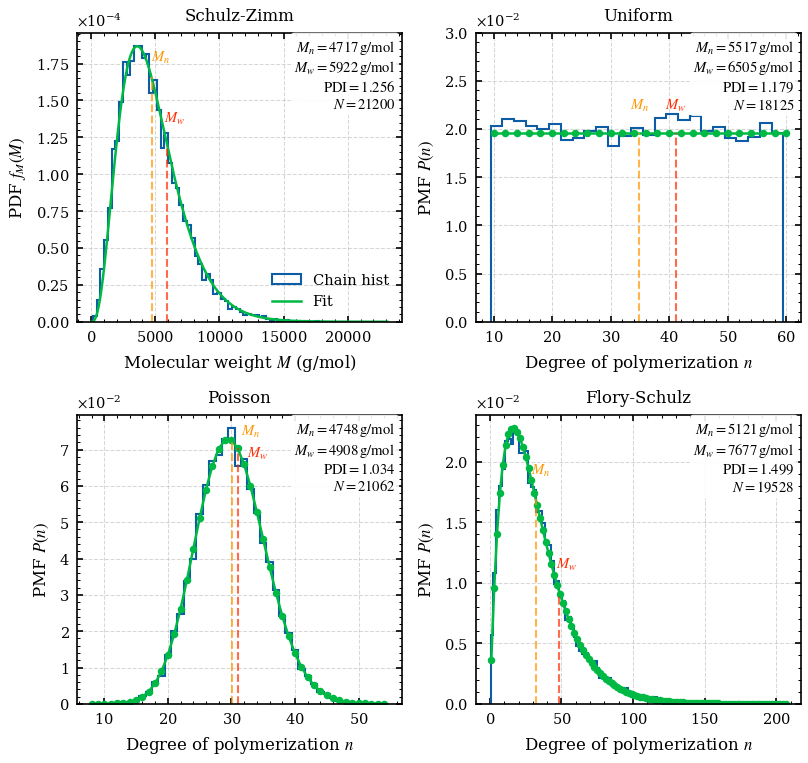


✅ Distribution plots generated (PMF/PDF-consistent)


<Figure size 495x375 with 0 Axes>

In [11]:
if __name__ == "__main__":
    main()

## Summary

### What We Accomplished

✅ **Parsed GBigSMILES** with distribution specifications

✅ **Created 4 distribution types**:
- Schulz-Zimm (continuous, realistic)
- Uniform (discrete, narrow)
- Poisson (discrete, controlled)
- Flory-Schulz (discrete, broad)

✅ **Sampled polymer chains** matching target mass

✅ **Computed statistics**: Mn, Mw, PDI for each distribution

✅ **Visualized results**: Compared sampled data vs theoretical curves

### Key Takeaways

1. **GBigSMILES enables declarative specification** of polydisperse systems
   - Distribution type and parameters in notation
   - No manual chain length calculations

2. **Different distributions suit different applications**:
   - Schulz-Zimm: Realistic experimental polymers
   - Uniform/Poisson: Controlled/living polymerization
   - Flory-Schulz: Step-growth polymerization

3. **Sampling matches theory**:
   - Histograms align with PDF/PMF curves
   - Mn, Mw close to theoretical values
   - PDI reflects distribution breadth

### Design Rationale

**Why separate mass-based vs DP-based distributions?**
- Schulz-Zimm: Experimental data often in MW
- Others: Chain length (DP) more intuitive

**Why use SystemPlanner?**
- Ensures target total mass is met
- Handles rounding/discretization
- Reproducible with random seed

### Next Steps

- **Build atomistic structures**: Use PolymerBuilder with these distributions
- **Run MD simulations**: Study property-structure relationships
- **Custom distributions**: Implement bimodal or experimental data
- **Analyze properties**: Rg, Tg, viscosity vs PDI

### Related Notebooks

- `polymer-step-by-step.ipynb`: Manual polymer building
- `polymer-linear-chain.ipynb`: Automated building with PolymerBuilder
- `polymer-crosslinked-network.ipynb`: Network structures

## Summary

### What We Accomplished

✅ **Parsed GBigSMILES** with distribution specifications

✅ **Created 4 distribution types**: Schulz-Zimm, Uniform, Poisson, Flory-Schulz

✅ **Sampled polymer chains** matching target mass

✅ **Computed statistics**: Mn, Mw, PDI for each distribution

✅ **Visualized results**: Compared sampled data vs theoretical curves

### Key Takeaways

1. **GBigSMILES enables declarative specification** of polydisperse systems - distribution type and parameters in notation
2. **Different distributions suit different applications**: Schulz-Zimm for realistic polymers, Uniform/Poisson for controlled polymerization, Flory-Schulz for step-growth
3. **Sampling matches theory**: Histograms align with PDF/PMF curves, Mn/Mw close to theoretical values

### Design Rationale

**Why separate mass-based vs DP-based distributions?** Schulz-Zimm uses MW (experimental data), others use DP (more intuitive).

**Why use SystemPlanner?** Ensures target total mass is met, handles rounding/discretization, reproducible with random seed.

### Next Steps

- **Build atomistic structures**: Use PolymerBuilder with these distributions
- **Run MD simulations**: Study property-structure relationships
- **Custom distributions**: Implement bimodal or experimental data
- **Analyze properties**: Rg, Tg, viscosity vs PDI

### Related Notebooks

- `polymer-step-by-step.ipynb`: Manual polymer building
- `polymer-linear-chain.ipynb`: Automated building
- `polymer-crosslinked-network.ipynb`: Network structures